In [2]:
import pandas as pd
data = pd.read_csv("cleaned_superstore_data.csv")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month
data['Day'] = data['Order Date'].dt.day

features = ['Sales', 'Quantity', 'Discount', 'Year', 'Month', 'Day', 'Category']
target = 'Profit'

data_encoded = pd.get_dummies(data[features + [target]], columns=['Category'])

data_encoded.head()

,Sales,Quantity,Discount,Year,Month,Day,Profit,Category_Furniture,Category_Office Supplies,Category_Technology
0,261.9600,2,0.00,2016,11,8,41.9136,True,False,False
1,731.9400,3,0.00,2016,11,8,219.5820,True,False,False
2,14.6200,2,0.00,2016,6,12,6.8714,False,True,False
3,957.5775,5,0.45,2015,10,11,-383.0310,True,False,False
4,22.3680,2,0.20,2015,10,11,2.5164,False,True,False


In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = data_encoded[['Sales', 'Quantity', 'Discount', 'Year', 'Month', 'Day', 'Category_Furniture', 'Category_Office Supplies' , 'Category_Technology']]
y = data_encoded['Profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
model.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(model, params, cv=5)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


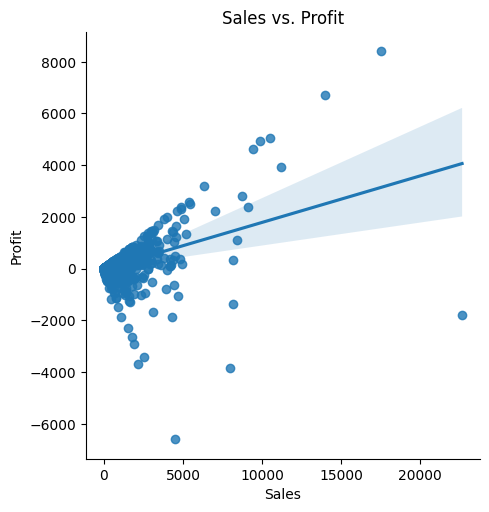

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lmplot(data=data, x='Sales', y='Profit', lowess=False)
plt.title('Sales vs. Profit')
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validated R²:", scores.mean())

Cross-Validated R²: 0.40569847631107053


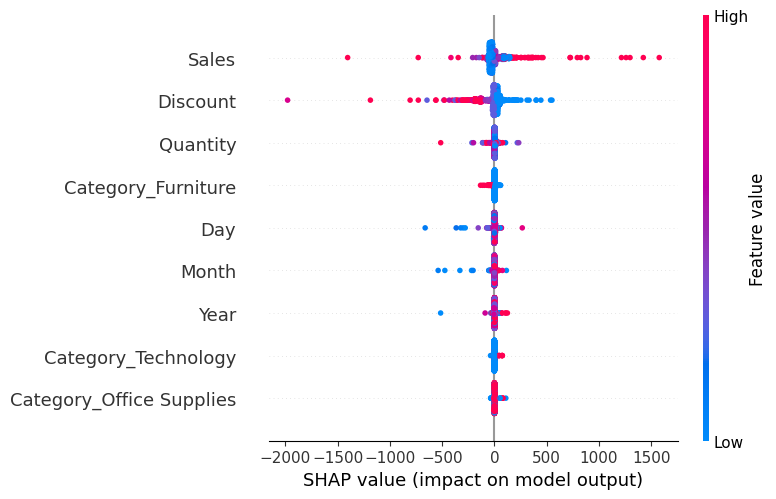

In [33]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

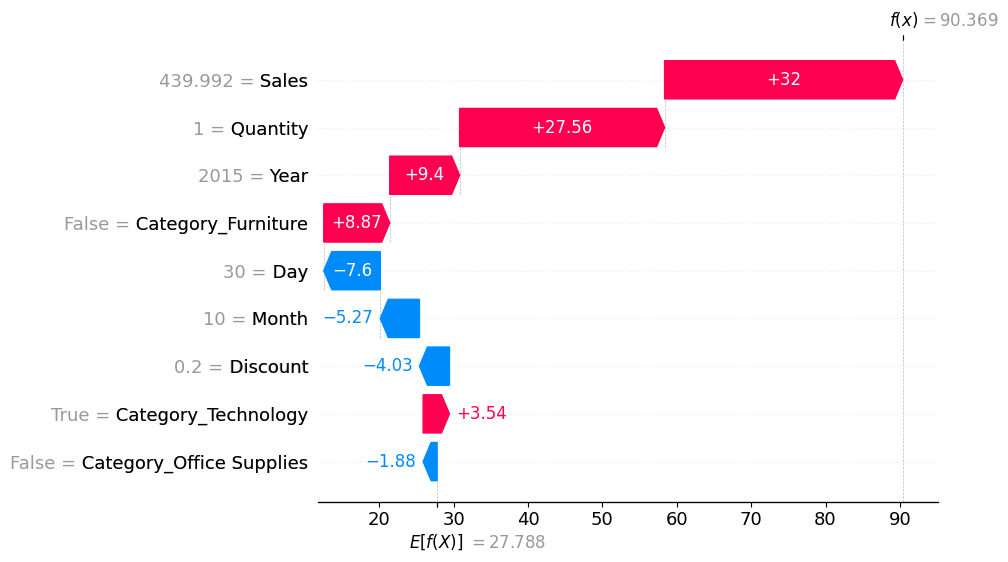

In [36]:
shap.plots.waterfall(shap_values[0])